In [1]:
from importlib import reload
import matplotlib.pyplot as plt
from math import nan
import numpy as np
import pandas as pd
import pickle as pkl
from tqdm import tqdm
from IPython import get_ipython

import myprofiler as mp
import cleantools as clnt

# Introducion #

This file is for exploration, cleaning, and saving of data.

In [2]:
def reporting(all_sheets):
    """This section takes a report of everything

    """
    print("Reporting each contracts sheet...")
    for name, df in tqdm(all_sheets.items()):
        mp.getReport(df, "_".join(name.split()))

Below are the basic variables defined to aid our process.

In [3]:
files = {
    "locations": "../data/locations_20200520_143742.xlsx",
    "persons": "../data/persons_20200520_143122.xlsx",
    "personMentions": "../data/person_mentions_20200520_143017.xlsx",
    "personRelationships": "../data/person_relationships_20200520_143219.xlsx",
    "professions": "../data/professions_20200520_143812.xlsx",
    "categories": "../data/profession_categories_20200520_143818.xlsx",
}
unrelated_colums = {
    "Financial Conditions": None,
    "personMentions": None,
    "persons": None,
    "personRelationships": None,
    "categories": None,
    "contracts": None,
    "Names": None,
    "Hosting Conditions": ["Type of Clothing"],
    "Locations": ["GeoNames ID"],
    "Events": [
        "End Date",
        "Duration - Years",
        "Duration - Months",
        "Duration - Days",
    ],
}
contracts_sheets = [
    "Contracts",
    "Person Mentions",
    "Hosting Conditions",
    "Financial Conditions",
    "Events",
]

Here is the report making and information extracting section.

In [ ]:
print("Extracting sheets from contracts...")
all_sheets = mp.readFromXlsx(
    "../data/contracts_20200520_142649.xlsx", contracts_sheets
)

print("Extracting Rest of the xlsx documents...")
for name, file in tqdm(files.items()):
    all_sheets[name] = mp.readFromXlsx(file)

print("Reporting all sheets...")
reporting(all_sheets)

# Deeper analysis #

First, we read the pickles we create along the way.

In [28]:
all_sheets = clnt.loadPickle("../data/pickles/all_sheets.pkl")

Now, we take a look at the *Duration* data in the *Events* sheet. Since it is split to three sections, we turn it to one numeric value for easier processing.

In [180]:
# Processing for better information
# Merging different duration data into one numeric column
events = all_sheets["Events"].copy()
events["Duration - Merged"] = (
    events["Duration - Years"] * 365
    + events["Duration - Months"] * 30
    + events["Duration - Days"]
)
events.loc[events["Start Date"].astype(str).apply(lambda x:len(x.split("-"))) < 3, "Start Date"] = "0000-00-00"
clnt.savePickle(events, "../data/pickles/clean_events.pkl")

Secondly, we explore the ages of apprentices, after cleaning up the string formatted entries.

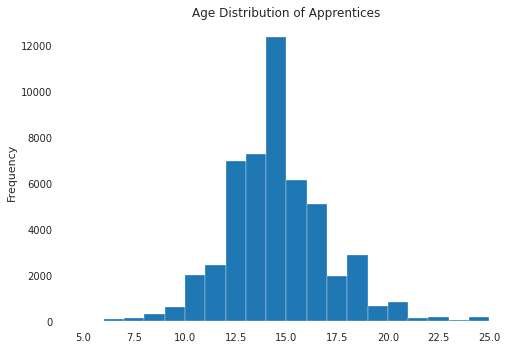

In [156]:
# Exploring apprentice age from person Mentions
temp = all_sheets["Person Mentions"].copy()
temp["Age - Standard Form"] = temp.loc[
    temp["Age"].apply(lambda x: clnt.isInt(x)), "Age"
]
temp["Professions - Standard Form"] = temp[
    "Professions - Standard Forms"
].copy()
temp = clnt.cleanColumns(
    temp, to_go=["Professions - Standard Forms", "Age"], eliminate_list=["Transcript"]
)

# clnt.savePickle(temp, "../data/pickles/clean_mentions.pkl")

temp = temp[temp["Tag"] == "grz:Apprentice"]
clnt.plotHist(temp["Age - Standard Form"], atype=float,
              title="Age Distribution of Apprentices", range=[5,25],
              bins=20)

## Payment Distribution ##

We check the distribution of full payments in a common currency.

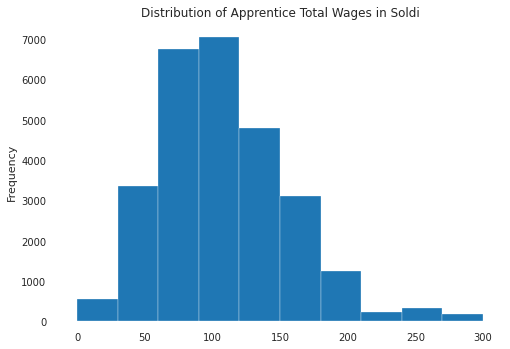

In [60]:
# Exploring the payment for apprenticeship
temp = all_sheets["Financial Conditions"].copy()
temp["Total - Standard Form"] = temp["Total Amount"] * temp[
    "Currency"
].apply(lambda x: clnt.currencyMap(x))
temp["Partial - Standard Form"] = temp["Partial Amount"] * temp[
    "Currency"
].apply(lambda x: clnt.currencyMap(x))
# clnt.savePickle(temp, "../data/pickles/clean_Financial.pkl")
clean_money = temp[temp["Paid in Goods"] == False]
clean_money = clean_money[clean_money["Paid by"] == "grz:MasterPayer"]

# After some experiment, this seems to be the best rate for visualization
clnt.plotHist(
    clean_money.loc[
        clean_money["Total - Standard Form"] > 0,
        "Total - Standard Form"],
    range=[0, 300], title="Distribution of Apprentice Total Wages in Soldi"
)



## Average Ages per Profession ##

In [73]:
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")
professions = all_sheets["professions"].copy()
temp = pd.merge(mentions[["Age - Standard Form", "Professions - Standard Form"]],
         professions[["Standard Form", "Category ID"]],
         left_on="Professions - Standard Form",
         right_on="Standard Form")
categories = all_sheets["categories"].copy()
temp = pd.merge(temp,
                categories[["Label", "Extended Label", "ID"]],
                left_on="Category ID", right_on="ID")[["Age - Standard Form",
                                                       "Professions - Standard Form",
                                                       "Label", "Extended Label"]]
temp["Age - Standard Form"] = pd.to_numeric(temp["Age - Standard Form"])

grouped_age = temp[["Age - Standard Form", "Label"]].groupby(["Label"]).agg(["mean", "count"])
grouped_age[(grouped_age[("Age - Standard Form", "mean")] > -1) &
            (grouped_age[("Age - Standard Form", "count")] > 20)].sort_values(("Age - Standard Form", "mean"), ascending=False)
# clnt.savePickle(grouped_age, "../data/pickles/age_with_prof_categories.pkl")

## Geo Origin Counts against the Profession ##

This section, due to its variant nature couldn't be analyzed as one frame, so I created a frame per profession for easy exploration.

In [238]:
# Get the mapping of profession to where they come from, for only
# apprentices
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")
professions = all_sheets["professions"].copy()
temp = pd.merge(mentions[["Geo Origin - Standard Form", "Professions - Standard Form"]],
         professions[["Standard Form", "Category ID"]],
         left_on="Professions - Standard Form",
         right_on="Standard Form")
temp = pd.merge(temp,
                categories[["Label", "ID"]],
                left_on="Category ID", right_on="ID")[["Geo Origin - Standard Form",
                                                       "Label"]]


geo_counts = dict()
u = temp["Label"].unique()
for label in tqdm(u):
    geo_counts[label] = temp[
        temp["Label"] == label].groupby([
        "Geo Origin - Standard Form"
    ]).size().to_frame(name = 'count').reset_index()
# clnt.savePickle(geo_counts, "../data/pickles/profession_labels_with_province_counts_dict.pkl")

100%|██████████| 173/173 [00:01<00:00, 136.00it/s]


## Profession's Affect on Income ##

First, we connect profession with a category label, then we average it and group it with the category label.

In [27]:
# Get the necessary datasets and exclude unnecessary variables
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")
apprentices = mentions[mentions["Tag"] == "grz:Apprentice"]
apprentices_trimmed = apprentices[["Contract ID", "Professions - Standard Form"]]
finances = clnt.loadPickle("../data/pickles/clean_Financial.pkl")[["Contract ID",
                                                                   "Total - Standard Form"]]
professions = all_sheets["professions"].copy()[["Standard Form", "Category ID"]]
categories = all_sheets["categories"].copy()[["ID", "Label"]]


# Merge the right connections
labels = pd.merge(professions, categories, left_on="Category ID", right_on="ID")[["Standard Form", "Label"]]
# clnt.savePickle(labels, "../data/pickles/profession_standards_to_label.pkl")

apprentices_trimmed = pd.merge(apprentices_trimmed, labels,
                               left_on="Professions - Standard Form",
                               right_on="Standard Form")[["Contract ID",
                                                          "Professions - Standard Form",
                                                          "Label"]]
jobs_w_pays = pd.merge(apprentices_trimmed, finances, on="Contract ID")
jwp_grouped = jobs_w_pays[["Label", "Total - Standard Form"]].groupby(["Label"]).agg(["mean","count"]).reset_index()
jwp_grouped[(jwp_grouped[("Total - Standard Form", "count")] > 5) &
            (jwp_grouped[("Total - Standard Form", "mean")] > 1)].sort_values(("Total - Standard Form", "mean"),
                                                                              ascending=False).head(10)

Label Total - Standard Form      
                                                              mean count
33                         editoria e stampa            767.857143     7
42              fabbr. di strumenti musicali            409.821429    28
30                              distillatura            249.615385    13
119                                purgatura            179.166667     6
60             impiallacciatura e/o intarsio            127.537879   132
56     fornitura di materiali per l'edilizia            119.873418    79
95                                     pelli            118.593750    32
152                         trasporto: merci            118.154762    84
4              altre tipologie merceologiche            116.336066   610
71   lavorazione della pietra per l'edilizia            115.415385   975

## Age's Effect on Income ##

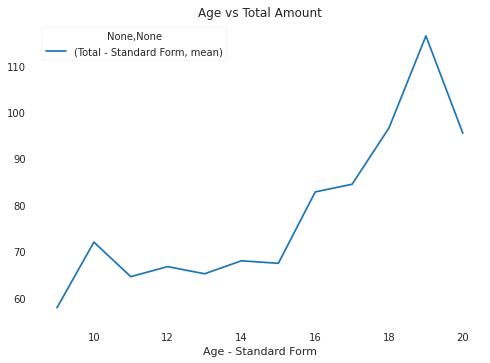

In [137]:
# Get necessary dataframes
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")
apprentices = mentions[mentions["Tag"] == "grz:Apprentice"]
apprentices_trimmed = apprentices[["Contract ID", "Age - Standard Form"]]
finances = clnt.loadPickle("../data/pickles/clean_Financial.pkl")[["Contract ID",
                                                                   "Total - Standard Form",
                                                                   "Paid by"]]
# Merging Process
age_w_money = pd.merge(apprentices_trimmed, finances, on="Contract ID")
age_w_money["Age - Standard Form"] = pd.to_numeric(age_w_money["Age - Standard Form"])
age_w_money = age_w_money[age_w_money["Paid by"] == "grz:MasterPayer"][["Age - Standard Form",
                                                                        "Total - Standard Form"]]
# Group and exclude non-master pays
age_w_money = age_w_money.groupby(["Age - Standard Form"]).agg(["mean", "count"]).reset_index()
awm_trimmed = age_w_money[(age_w_money[("Total - Standard Form", "count")] > 500) &
                          (age_w_money[("Total - Standard Form", "mean")] > 0)]
awm_trimmed.plot.line("Age - Standard Form", ("Total - Standard Form", "mean"),
                      title="Age vs Total Amount")

This graph is regardless of the time duration. Assuming all ages have done all amounts of apprenticeship time, the graph aboe should be accurate. However, since this is a big assumption, we are going to normalize the amount to per month.

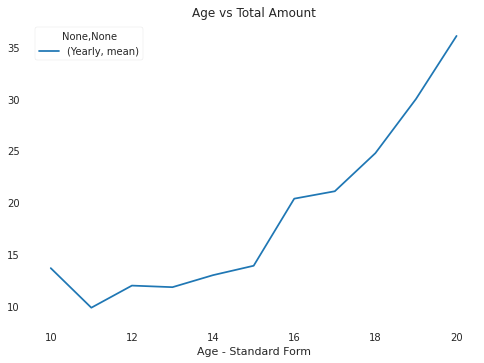

In [138]:
# Load dataframes
events = clnt.loadPickle("../data/pickles/clean_events.pkl")
age_w_money = pd.merge(apprentices_trimmed, finances, on="Contract ID")
age_w_money = pd.merge(age_w_money, events, on="Contract ID")

# Exclude unnecessary sections, and adjust to time
awm_timed = age_w_money[age_w_money["Paid by"] == "grz:MasterPayer"]
awm_timed = awm_timed[(awm_timed["Duration - Merged"] > 0) &
                      (awm_timed["Total - Standard Form"] < 9999999)]
awm_timed["Yearly"] = awm_timed["Total - Standard Form"] / awm_timed["Duration - Merged"] * 365
awm_timed = awm_timed[["Age - Standard Form", "Yearly", "Total - Standard Form", "Duration - Merged"]]
awm_timed.sort_values("Yearly", ascending = False)
awm_timed = awm_timed[["Age - Standard Form", "Yearly"]]

# Group and plot
awm_grouped = awm_timed.groupby(["Age - Standard Form"]).agg(["mean", "count"]).reset_index()
# awm_grouped.sort_values(("Yearly", "count"), ascending = False)
awm_grouped = awm_grouped[(awm_grouped[("Yearly", "mean")] > 0) &
                          (awm_grouped[("Yearly", "mean")] < 9999999) &
                          (awm_grouped[("Yearly", "count")] > 450)]
awm_grouped.plot.line("Age - Standard Form", ("Yearly", "mean"),
                      title="Age vs Total Amount")

## Exploration of a New Table ##

Here we generate one table of contracts and integrate only the sections that we will focus on in the main search, and do a deep analysis of it with correlation checks. The table will include:

- Contract ID
- Master(s)
- Apprentice
- Any extra people
- Is there money exchange
- Does Master Pay
- Is the payment period whole?
- Is the origin in italy?
- What type of place
- Where is the origin

In [428]:
# Load dataframes
contracts = all_sheets["Contracts"].copy()[["Contract ID",
                                            "Date"]]
events = clnt.loadPickle("../data/pickles/clean_events.pkl")[["Contract ID",
                                                              "Tag",
                                                              "Start Date",
                                                              "Duration - Merged"]]
financials = clnt.loadPickle("../data/pickles/clean_Financial.pkl")[["Contract ID",
                                                                     "Tag",
                                                                     "Paid by",
                                                                     "Paid in Goods",
                                                                     "Periodization",
                                                                     "Currency",
                                                                     "Total Amount"]]
hosting = all_sheets["Hosting Conditions"][["Contract ID",
                                            "Tag",
                                            "Paid by",
                                            "Paid in Goods"]]
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")[["Contract ID",
                                                                  "Gender",
                                                                  "Age - Standard Form",
                                                                  "Geo Origin - Standard Form",
                                                                  "Workshop - Site",
                                                                  "Professions - Standard Form",
                                                                  "Person ID",
                                                                  "Tag"]]

In [429]:
# Prepare each row for easier understanding
# TODO: Dont forget to convert dates to datetime in the end
# Turn events into one-hot encoding on three different column
events_tags = clnt.hotEncode(events, events.Tag)
events_tags = events_tags.loc[events_tags["grz:Apprenticeship"] != 0, ["Contract ID", "grz:BreachOfContract", "grz:Flee"]]
events_tags.columns = ["Contract ID", "Has BoContract", "Has Flee"]
the_table = pd.merge(contracts, events_tags, on = "Contract ID")

# events[(events["Tag"]!= "grz:Apprenticeship") & (events["Duration - Merged"].astype(float) > 0)]
# After the check above, its been deciced that the events with duration which are not apprenticeships
# are very little, so they can be ignored
# On the other hand, breach and flee dates are pretty abundant, neet to incorparate them in.

In [430]:
# Financial Tags extracted to encoding
financial_tags = clnt.hotEncode(financials, financials.Tag)
financial_tags = financial_tags[["Contract ID", "grz:SingleSalary"]]
financial_tags.columns = ["Contract ID", "Has Single Salary"]
the_table = the_table.merge(financial_tags, on="Contract ID")

In [431]:
# Financial Paid by extracted
financial_paidby = clnt.hotEncode(financials, financials["Paid by"])[["Contract ID", "grz:MasterPayer"]]
financial_paidby.columns = ["Contract ID", "Has Master Paying Salary"]
the_table = the_table.merge(financial_paidby, on="Contract ID")

In [432]:
# Financial Periodization
financial_periodization = clnt.hotEncode(financials, financials.Periodization)[["Contract ID", "grz:WholePeriod"]]
financial_periodization.columns = ["Contract ID", "Has Whole Period"]
the_table = the_table.merge(financial_periodization, on="Contract ID")

In [433]:
# Financial Currency
financial_currency = clnt.hotEncode(financials, financials.Currency)#[["Contract ID", "grz:Ducati"]]
# financial_currency.columns = ["Contract ID", "Has Ducati"]
financial_currency.columns = ["Contract ID", "Has Ducati", "Has Soldi", "Has Lire", "Has Other Currency"]
the_table = the_table.merge(financial_currency, on="Contract ID")

In [434]:
# Hosting Paid by
temp = hosting[hosting["Paid in Goods"] == False]
hosting_paid = clnt.hotEncode(temp, temp["Paid by"])
hosting_paid.columns = ["Contract ID", "Apprentice Paid X Times", "Master Paid X Times", "Others Paid X Times"]
the_table = the_table.merge(hosting_paid)

In [435]:
# Hosting Tag
hosting_tag = clnt.hotEncode(temp, temp.Tag)
hosting_tag.columns = ["Contract ID", "Has Accommodation Payed", "Has Clothing Payed", "Has Generic Expenses Payed", "Has Personal Care Payed"]
the_table = the_table.merge(hosting_tag, on="Contract ID")

In [436]:
# Rest of the sections to add
the_table = the_table.merge(events.loc[events["Tag"] == "grz:Apprenticeship",
                           ["Contract ID","Duration - Merged"]], on="Contract ID")
financials_slice = financials[["Contract ID", "Paid in Goods", "Total Amount"]]
financials_slice.columns = ["Contract ID", "Paid Salary in Goods", "Total Payment Received"]
the_table = the_table.merge(financials_slice, on="Contract ID")

mentions_slice = mentions.loc[mentions["Tag"] == "grz:Apprentice", mentions.keys()[:-1]]
the_table = the_table.merge(mentions_slice, on="Contract ID")

# Formatting and indexing
the_table["Date"] = pd.to_datetime(the_table["Date"], errors="coerce")
the_table["Age - Standard Form"] = pd.to_numeric(the_table["Age - Standard Form"], errors="coerce")
the_table["Paid Salary in Goods"] = the_table["Paid Salary in Goods"].apply(lambda x:1 if x else 0)
the_table = the_table.set_index("Contract ID")

In [439]:
clnt.savePickle(the_table, "../data/pickles/table_of_all.pkl")

# Main Research #

From here on, we will be exploring the connections of location data to multiple things, and the social network of 